# Nonlinear Buckling Analysis of the uCRM-9

In our [notebook 0](00_Failed_Attempt_of_the_Nonlinear_Buckling_Analysis_of_the_uCRM-9.ipynb) we tried to blindly apply Nastran's nonlinear buckling method to the uCRM-9, but we failed to obtain any meaningful results. After the nonlinear buckling analyses on the different box beam configurations and the investigation of their equilibrium paths, we are finally ready to study the nonlinear buckling behavior of the uCRM-9.

* [Setup of the numerical model](#numerical-model)
* [Linear buckling analysis](#linear-buckling)
* [Nonlinear analysis: natural equilibrium path](#natural-path)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
* [Nonlinear analysis: investigation on complementary equilibrium paths](#complementary-paths)
* [Nonlinear analysis: nonlinear buckling method verification](#nonlinear-buckling-method-verification)
* [Conclusion](#conclusion)

In [1]:
import matplotlib.pyplot as plt  # import matplotlib
import tol_colors as tc  # import package for colorblind-friendly colors
from matplotlib.lines import (
    Line2D,
)  # class defining the characters for the marker styles
import os

# Set default plot settings
plt.rc(
    "axes", prop_cycle=plt.cycler("color", list(tc.tol_cset("bright")))
)
plt.rcParams["figure.dpi"] = 120  # set default dpi of figures
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
COLORS = plt.rcParams["axes.prop_cycle"].by_key()[
    "color"
]  # retrieve list with succession of standard matplotlib colors
AMPLIFICATION_FACTOR = 100  # amplification factor for displacements

# Enable interactive plots
%matplotlib widget

# Constants - Nastran subcase IDs
FIRST_SUBCASE_ID = 1
SECOND_SUBCASE_ID = 2

# Constants - Nastran card IDs
LOAD_SET_ID = 11
ZERO_LOAD_SET_ID = 12
METHOD_SET_ID = 13

# Constants - displacement and load component indices
Z_INDEX = 2  # translation along z-axis

# Define path to analysis directory
analysis_directory_name = "17_Nonlinear_Buckling_Analysis_of_the_uCRM-9"
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

## Setup of the numerical model <a name="numerical-model"></a>

***

The uCRM-9 is a flexible version of NASA's Common Research Model (CRM, [Vassberg et al. 2008](https://arc.aiaa.org/doi/abs/10.2514/6.2008-6919)) developed by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603). The structural mesh files for the aluminum wingbox structure including material properties based on a smeared stiffness blade-stiffened panel approach can be found on [this Mendeley Data page](https://data.mendeley.com/datasets/gpk4zn73xn/1). On the same page it is possible to find also the Nastran input file including the aerodynamic loads for the nominal 1g cruise and the run files for linear static analysis (SOL 101) and modal analysis (SOL 103).

To use the uCRM-9 model, we start by initializing an empty `BDF` object. Then we create a case control deck requesting displacements and applied loads to be stored in the op2 file and we include the bdf file with the structural mesh of the wingbox in our `BDF` object. The bdf file contains also the `SPC` cards defining the single point constraint applied to the model. We record the the id of those cards and add it to the case control deck.

In [2]:
from pyNastran.bdf.bdf import BDF

# Initialize BDF object
ucrm9_bdf = BDF(debug=None)

# Create case control deck
ucrm9_bdf.create_subcases(0)
ucrm9_bdf.case_control_deck.subcases[0].add(
    "ECHO", "NONE", [], "STRING-type"
)  # request no Bulk Data to be printed
ucrm9_bdf.case_control_deck.subcases[0].add_result_type(
    "DISPLACEMENT", "ALL", ["PLOT"]
)  # store displacement data of all nodes in the op2 file
ucrm9_bdf.case_control_deck.subcases[0].add_result_type(
    "OLOAD", "ALL", ["PLOT"]
)  # store form and type of applied load vector

# Include structural mesh
ucrm9_bdf.add_include_file(
    os.path.join(
        os.pardir, os.pardir, "resources", "uCRM-9", "uCRM-9_wingbox_coarse.bdf"
    )
)  # structural model of the wingbox
spc_id = 1  # SPC ID for the boundary condition
ucrm9_bdf.case_control_deck.subcases[0].add_integer_type(
    "SPC", spc_id
)  # assign SPC id to case control deck

subcase=0 already exists...skipping


Then we add some `PARAM` cards to replicate the settings prescribed in the original run files.

In [3]:
ucrm9_bdf.add_param(
    "AUTOSPC", ["NO"]
)  # singularities in the stiffness matrix will not be constrained
ucrm9_bdf.add_param(
    "GRDPNT", [1]
)  # execute grid point weight generator using node with id 1 as reference point
ucrm9_bdf.add_param(
    "K6ROT", [1e5]
)  # specifies the scaling factor of the penalty stiffness to be added to the normal rotation for CQUAD4 and CTRIA3 elements
ucrm9_bdf.add_param(
    "COUPMASS", [-1]
)  # causes the generation of lumped mass matrices (which may include torsion inertia for beam elements, and some coupling if there are beam offsets) for the CQUAD4 and CTRIA3 elements
ucrm9_bdf.add_param(
    "MAXRATIO", [1e7]
)  # threshold for the ratios of terms on the diagonal of the stiffness matrix to the corresponding terms on the diagonal of the triangular factor above which the matrix will be considered to be nearly singular
ucrm9_bdf.add_param("POST", [1])  # store results in a op2 file
ucrm9_bdf.add_param(
    "WTMASS", [1.0]
)  # the terms of the structural mass matrix are multiplied by the value of WTMASS when they are generated

PARAM     WTMASS      1.

In this notebook we want to use the aerodynamic load of the 1g cruise condition and scale it uniformly, with the aim of analyzing the nonlinear behavior of the uCRM-9 under a pseudo-aerodynamic load. For this reason, we include the bdf file containing the `FORCE` cards that describe the 1g aerodynamic load in our `BDF` object, and we record the id of the cards.

In [4]:
ucrm9_bdf.add_include_file(
    os.path.join(
        os.pardir,
        os.pardir,
        "resources",
        "uCRM-9",
        "uCRM-9_aero_forces_1.0g_coarse.bdf",
    )
)  # aerodynamic 1g load
force_id = 1  # force ID for the aerodynamic load

## Linear buckling analysis <a name="linear-buckling"></a>

***

 We run a linear buckling analysis with SOL 105 calling the function `run_sol_105` from the `pynastran_utils` module. Then we find the critical buckling factor and we plot the associated buckling mode together with the node where the maximum displacement occurs.

Nastran job linear_buckling.bdf completed
Wall time: 16.0 s
Buckling factor: 2.9


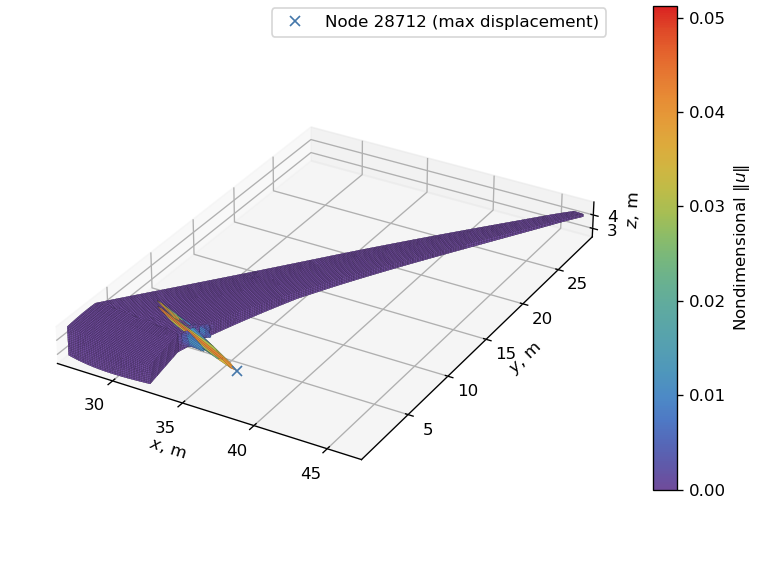

In [5]:
from resources import pynastran_utils, plot_utils
import numpy as np

# Run analysis
input_name = "linear_buckling"
sol_105_op2 = pynastran_utils.run_sol_105(
    bdf=ucrm9_bdf.__deepcopy__({}),
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    static_load_set_id=force_id,
    method_set_id=METHOD_SET_ID,
    run_flag=False,
)

# Find critical buckling factor and print it
sol_105_buckling_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigr
print(f"Buckling factor: {sol_105_buckling_factor:.1f}")

# Plot buckling mode
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2,
    subcase_id=SECOND_SUBCASE_ID,
    displacement_component="magnitude",
    displacement_amplification_factor=AMPLIFICATION_FACTOR,
)
ax.tick_params(
    axis="z", which="major", pad=-1
)  # adjust position of ticks' label of z-axis
ax.zaxis.labelpad = -6  # adjust position of y-axis's label
ax.locator_params(axis="x", nbins=8)  # set number of ticks of z-axis
ax.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, 0.84))  # decrease colorbar size
cbar.ax.set_position(
    cbar.ax.get_position().translated(0.0, 0.15)
)  # move colorbar upwards

# Find node where max displacement occurs
max_displacement_index = np.argmax(
    np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1)
)  # find index of max displacement magnitude
MAX_DISPLACEMENT_NODE_ID = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[
    max_displacement_index, 0
]
max_displacement_node_xyz = (
    sol_105_op2.nodes[MAX_DISPLACEMENT_NODE_ID].xyz
    + AMPLIFICATION_FACTOR
    * sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]
)

# Plot node and show overall plot
ax.plot(
    max_displacement_node_xyz[0],
    max_displacement_node_xyz[1],
    max_displacement_node_xyz[2],
    "x",
    label=f"Node {MAX_DISPLACEMENT_NODE_ID:d} (max displacement)",
    zorder=4,
)
ax.legend()
plt.show()

As observed in our [notebook 0](00_Failed_Attempt_of_the_Nonlinear_Buckling_Analysis_of_the_uCRM-9.ipynb), the buckling load factor is equal to $2.9$, meaning that according to the linear analysis the applied load would have to be increased by a factor of $2.9$ to cause the structure to buckle. The predicted critical buckling mode involves the section of the rear spar immediately after the kink.

## Nonlinear analysis: natural equilibrium path <a name="natural-path"></a>

***

Now we want to investigate what the natural equilibrium path of the uCRM-9 under the pseudo-aerodynamic load looks like. To do this, we create a static load subcase where we apply twice the critical buckling load predicted by SOL 105.

In [6]:
BUCKLING_LOAD_SCALE_FACTOR = 2  # scale factor of buckling load
ucrm9_bdf.add_load(
    sid=LOAD_SET_ID,
    scale=1.0,
    scale_factors=[sol_105_buckling_factor * BUCKLING_LOAD_SCALE_FACTOR],
    load_ids=[force_id],
)  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(
    bdf=ucrm9_bdf, subcase_id=1, load_set_id=LOAD_SET_ID
)  # create subcase with defined load set

Then we need to add an option to change all `CQUADR` cards into `CQUAD4` cards, as SOL 106 cannot work with the former type of elements.

In [7]:
ucrm9_bdf.system_command_lines[0:0] = ["NASTRAN QRMETH=3"]

We run our nonlinear analysis using fine arc-length increments, obtained by setting the following parameters:

- $\Delta\mu^1=0.01$;
- $\mathrm{MAXITER}=5$;
- load and displacement error functions with vector component method;
- $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$;
- $\mathrm{MAXBIS}=10$;
- $\mathrm{MINALR}=0.01$;
- $\mathrm{MAXALR}=1.0001$;
- $\mathrm{DESITER}=5$;
- $\mathrm{MXINC}=1000$.

This parameters are inspired from the shallow cylindrical shell snap-through example from the _MSC Nastran Demontration Problems Guide - Implicit Nonlinear_. Based on the results of [notebook 15](15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs.ipynb#visualization), we also set $\mathrm{MAXITER}=5$ to prevent the arc-length solver from jumping from one equilibrium path to another.

In [8]:
# Set up arc-length method with fine increments
pynastran_utils.set_up_arc_length_method(
    bdf=ucrm9_bdf,
    ninc=100,
    max_iter=5,
    conv="PUV",
    eps_p=1e-3,
    eps_u=1e-3,
    max_bisect=10,
    minalr=0.01,
    maxalr=1.0001,
    desiter=5,
    maxinc=1000,
)

Let's run the nonlinear analysis with the function `run_sol_106_with_kllrh_eigenvalues` from the `pynastran_utils` module. We monitor the 10 smallest magnitude eigenvalues of the tangent stiffness matrix to assess the stability of the equilibrium points found by the analysis.

In [9]:
input_name = "natural_equilibrium_path_verification"
no_eigenvalues = (
    10  # number of eigenvalues to be calculated for each converged increment
)
sol_106_natural_path_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=ucrm9_bdf.__deepcopy__({}),
    method_set_id=METHOD_SET_ID,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    no_eigenvalues=no_eigenvalues,
    run_flag=False,
)

Nastran job natural_equilibrium_path_verification.bdf completed
Wall time: 3546.0 s


Similarly to our last notebooks, we want to visualize the results of the analysis by means of a 3D equilibrium path representing the variation of a global and a local displacement of the structure with the applied load. As usual, to represent the global displacment we consider the vertical tip displacement ($z$-direction) and we nondimensionalize it with the length $l$ of our structure, corresponding to half the uCRM-9 wingspan.

For the local displacement, similarly to our previous notebooks, we want to consider the node where the linear buckling analysis predicts the maximum displacement. However, this time the critical buckling mode involves the out-of-plane deformation of the rear spar, which occurs mostly along the $x$-axis. For this reason we consider the displacement of the mentioned node in the $x$-direction, and we use the height of the rear spar at the root of the wingbox to nondimensionalize it.

In [10]:
TIP_NODE_ID = 11847  # id of node used to monitor tip displacement
Z_COMPONENT_INDEX = 2  # index of z-component of displacement and load vector
L = 58.76 / 2  # half of uCRM-9 wingspan [m]
X_COMPONENT_INDEX = 0  # index of x-component of displacement and load vector
H_TE = 1.297  # uCRM-9 trailing edge spar height at the root [m]

At this point, we read the load and displacement history from the `OP2` object returned by the function `run_sol_106_with_kllrh_eigenvalues`.

In [11]:
FIRST_SUBCASE_ID = 1  # id of first subcase
LOAD_STEPS_NATURAL_PATH, _, displacements_dict = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_natural_path_op2, node_ids=[TIP_NODE_ID, MAX_DISPLACEMENT_NODE_ID]
    )
)  # read nondimensional applied loads and tip displacements
TIP_DISPLACEMENTS_NATURAL_PATH = displacements_dict[TIP_NODE_ID]
LOCAL_DISPLACEMENTS_NATURAL_PATH = displacements_dict[MAX_DISPLACEMENT_NODE_ID]

To plot the natural equilibrium path we define the function `plot_natural_equilibrium_path`, which creates a new figure with a 3D axis and plots the corresponding applied loads against the tip and local displacements. We will use this function also later for the sensitivity study on the nonlinear analysis parameters and for the investigation on the complementary equilibrium paths.

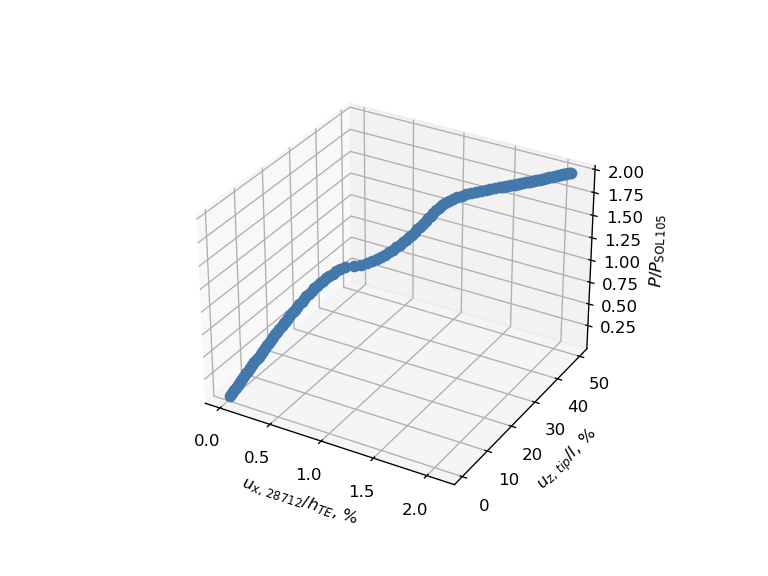

In [12]:
def plot_natural_equilibrium_path():
    # Create 3D plot of equilibrium diagram
    plt.figure()
    ax_3d = plt.axes(projection="3d")
    ax_3d.plot3D(
        LOCAL_DISPLACEMENTS_NATURAL_PATH[FIRST_SUBCASE_ID][:, X_COMPONENT_INDEX]
        / H_TE
        * 100,
        TIP_DISPLACEMENTS_NATURAL_PATH[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]
        / L
        * 100,
        LOAD_STEPS_NATURAL_PATH[FIRST_SUBCASE_ID] * BUCKLING_LOAD_SCALE_FACTOR,
        "o-",
        label="natural equilibrium path",
    )
    return ax_3d


# Plot natural equilibrium path found in last analysis
ax = plot_natural_equilibrium_path()

# Set plot appearance
ax.set_xlabel(f"$u_{{x,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/h_{{TE}}$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax.grid(visible=True)
plt.show()

The equilibrium path shows evident nonlinearities in the structural response. Let's have a look at the eigenvalues of the tangent stiffness matrix to verify the stability of the structure along the equilibrium path.

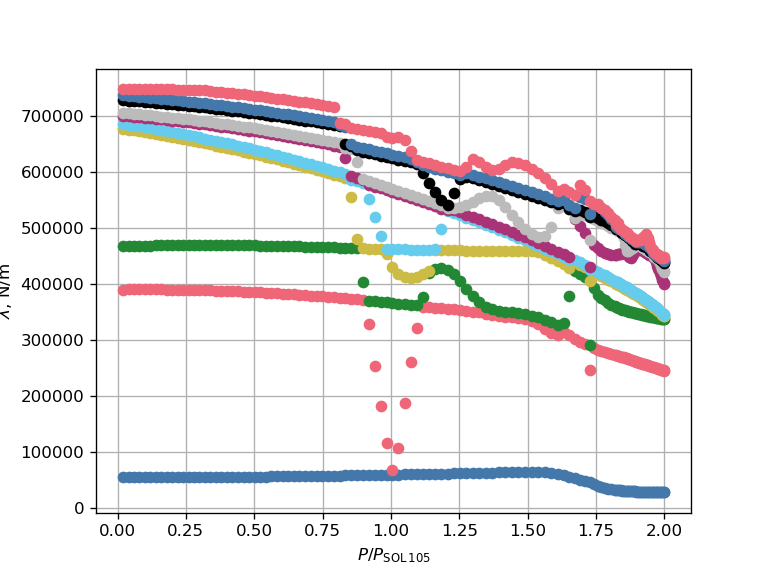

In [13]:
# Read eigenvalues from f06 file
f06_filepath = os.path.join(
    ANALYSIS_DIRECTORY_PATH, input_name + ".f06"
)  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Plot eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(
    LOAD_STEPS_NATURAL_PATH[FIRST_SUBCASE_ID] * BUCKLING_LOAD_SCALE_FACTOR,
    eigenvalues.T * 1e3,
    "o",
)  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{SOL\,105}$")
ax.grid(visible=True)
plt.show()

From the plot above we can infer that the structure follows a stable natural equilibrium path for the full range of the applied loads. We observe an unexpected isolated eigenvalue close to $P/P_\text{SOL 105}=1.75$, which does not seem to belong to any eigenvalue curve. However, all other eigenvalues do not show discontinuities, and also the natural equilibrium path does not seem to present any jump. This means that most probably there is no jump in the traced equilibrium path and that the isolated eigenvalue corresponds to the trough of a very narrow eigenvalue curve, which is hard to visualize in the plot above and would require finer arc-length increments to be captured.

Finally, let's visualize the deformed shape of the structure at $P/P_\text{SOL 105}=2$, displaying the rotation of the elements around the $x$, $y$ and $z$ axes to check the presence of buckling-like shapes.

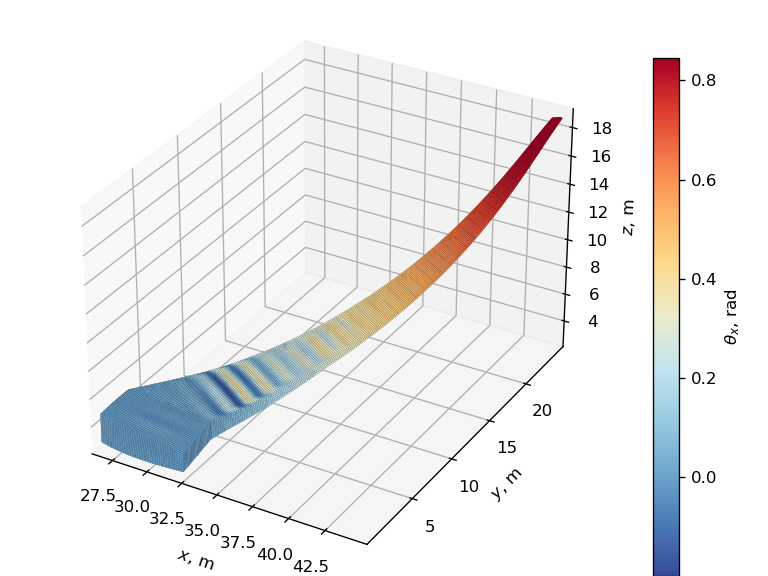

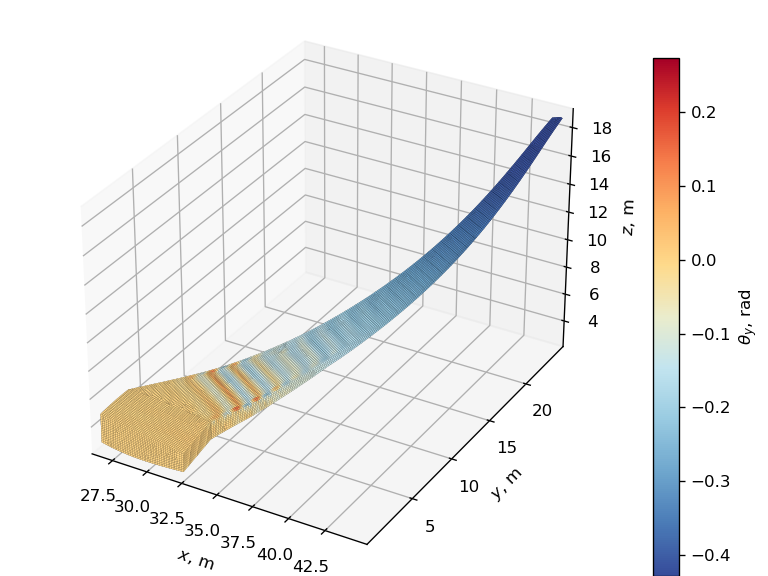

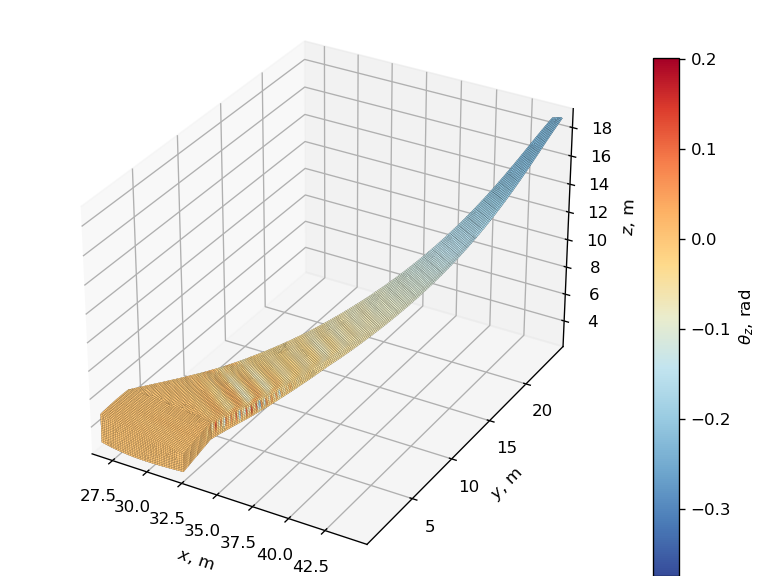

In [14]:
for component in ["rx", "ry", "rz"]:
    _, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_natural_path_op2,
        displacement_component=component,
        colormap="sunset",
    )
    ax.locator_params(axis="x", nbins=8)  # set number of ticks of z-axis
    cbar.ax.set_position(
        cbar.ax.get_position().shrunk(1.0, 0.9)
    )  # decrease colorbar size

The above plots clearly show the presence of buckling-like shapes over the top skin and the rear spar, and more mildly over the front spar. The nonlinear response shown by the natural equilibrium path is consistent with the presence of a buckling-like shape over the rear spar.

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Similarly to our previous box beam models, now we want to investigate the influence of SOL 106's nonlinear analysis parameters on the results of the analysis. Once again, we are going to vary several parameters of the `NLPARM` and the `NLPCI` cards and observe how the load-displacement diagram changes. This time we are going to monitor the changes in the 3D equilibrium path and compare it with the natural equilibrium path, in order to get a more insightful visualization.

We start by adding a new `NLPARM` and `NLPCI` card with default parameters to our `BDF` object, and we assign them to the control deck of the first subcase. The only non-default parameter that we set is $\mathrm{MAXITER}=5$, as we want to prevent the arc-length solver from jumping from one equilibrium path to another.

In [15]:
sensitivity_nlparm_id = 2
pynastran_utils.set_up_arc_length_method(
    bdf=ucrm9_bdf,
    nlparm_id=sensitivity_nlparm_id,
    subcase_id=FIRST_SUBCASE_ID,
    max_iter=5,
)

Before starting our investigation, we define the function `plot_3d_load_displacement_diagram` to run the Nastran analysis, read the load and displacement history from the resulting op2 file and plot the 3D equilibrium diagram on a pre-defined figure, where, for reference, we are also going to plot the natural equilibrium path.

In [16]:
from pyNastran.op2.op2 import read_op2


def plot_3d_load_displacement_curve(
    bdf_input,
    filename,
    axes,
    load_scale_factor,
    marker_style,
    line_label,
    run_flag=False,
):
    # Run analysis
    pynastran_utils.run_analysis(
        directory_path=ANALYSIS_DIRECTORY_PATH,
        bdf=bdf_input,
        filename=filename,
        run_flag=run_flag,
    )
    # Read load and displacement history from op2 file
    op2_path = os.path.join(ANALYSIS_DIRECTORY_PATH, filename + ".op2")
    op2 = read_op2(op2_path, debug=None)
    step, _, disp_dict = pynastran_utils.read_load_displacement_history_from_op2(
        op2=op2, node_ids=[TIP_NODE_ID, MAX_DISPLACEMENT_NODE_ID]
    )
    tip_disp = disp_dict[TIP_NODE_ID]
    local_disp = disp_dict[MAX_DISPLACEMENT_NODE_ID]
    # Plot load-displacement curve on input axes
    axes.plot(
        local_disp[FIRST_SUBCASE_ID][:, X_COMPONENT_INDEX] / H_TE * 100,
        tip_disp[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX] / L * 100,
        step[FIRST_SUBCASE_ID] * load_scale_factor,
        marker=marker_style,
        linestyle="-",
        label=line_label,
    )

### Error function

We start our sensitivity study considering four different combinations of error functions:

- load and energy (default);
- load and energy with vector component checking;
- load and displacement;
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking.

In [17]:
error_functions = ["PW", "PWV", "PU", "PUV", "PWU", "PWUV"]

We run the analyses varying the error function in the `NLPARM` card and we plot the results.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 464.0 s
Nastran job nonlinear_analysis_error_function_PWV.bdf completed
Wall time: 466.0 s
Nastran job nonlinear_analysis_error_function_PU.bdf completed
Wall time: 520.0 s
Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 502.0 s
Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 504.0 s
Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 504.0 s


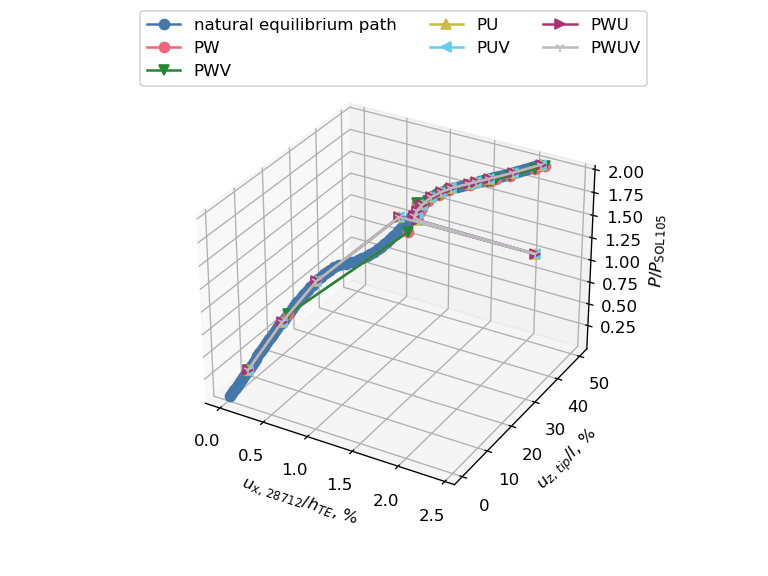

In [18]:
ax = (
    plot_natural_equilibrium_path()
)  # create new figure and plot natural equilibrium path

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    ucrm9_bdf.nlparms[sensitivity_nlparm_id].conv = fun
    input_name = "nonlinear_analysis_error_function_" + fun
    plot_3d_load_displacement_curve(
        ucrm9_bdf,
        input_name,
        ax,
        BUCKLING_LOAD_SCALE_FACTOR,
        MARKERS[count],
        f"{fun}",
        run_flag=False,
    )

# Set plot appearance
ax.set_xlabel(f"$u_{{x,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/h_{{TE}}$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_\mathrm{SOL\/105}$")
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=3)
plt.grid()
plt.show()

We observe that the only difference among the different load-displacement curves is associated to the use of the displacement error function. In fact, all analyses employing the displacement error function converge to the same equilibrium points, and all analyses not employing it converge to another set of equilibrium points.

Overall the majority of the equilibrium points fall on the natural equilibrium path, however a few points are found off the natural path for both families of curves (more evidently for the family of curves obtaine with the use of the displacement error function, while for the other curves it is necessary to zoom in a bit). This result suggests that the arc-length solver is jumping to a complementary path and then back to the natural path, as in the end all the analyses appear to converge to approximately the same final equilibrium point.

### Convergence tolerance

The second parameter that we consider is the convergence tolerance. However, we want to investigate the effect of convergence tolerances for both families of load-displacement curves, that is to say with and without the dispalcement error function. For this reason we define three combinations of convergence tolerances and we apply each combination to one analysis using the load and displacement error functions and to another analysis employing the load and energy error functions.

We consider the following combinations of convergence tolerances, inspired from table 21 of _MSC Nastran Quick Reference Guide_ manual:

- $\mathrm{EPSP}=\mathrm{EPSU}=\mathrm{EPSW}=10^{-1}$;
- $\mathrm{EPSP}=\mathrm{EPSU}=10^{-2},\,\mathrm{EPSW}=10^{-3}$;
- $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3},\,\mathrm{EPSW}=10^{-7}$.

Nastran job nonlinear_analysis_error_function_PW_epsp1e-01.bdf completed
Wall time: 274.0 s
Nastran job nonlinear_analysis_error_function_PW_epsp1e-02.bdf completed
Wall time: 418.0 s
Nastran job nonlinear_analysis_error_function_PW_epsp1e-03.bdf completed
Wall time: 552.0 s
Nastran job nonlinear_analysis_error_function_PU_epsp1e-01.bdf completed
Wall time: 357.0 s
Nastran job nonlinear_analysis_error_function_PU_epsp1e-02.bdf completed
Wall time: 461.0 s
Nastran job nonlinear_analysis_error_function_PU_epsp1e-03.bdf completed
Wall time: 540.0 s


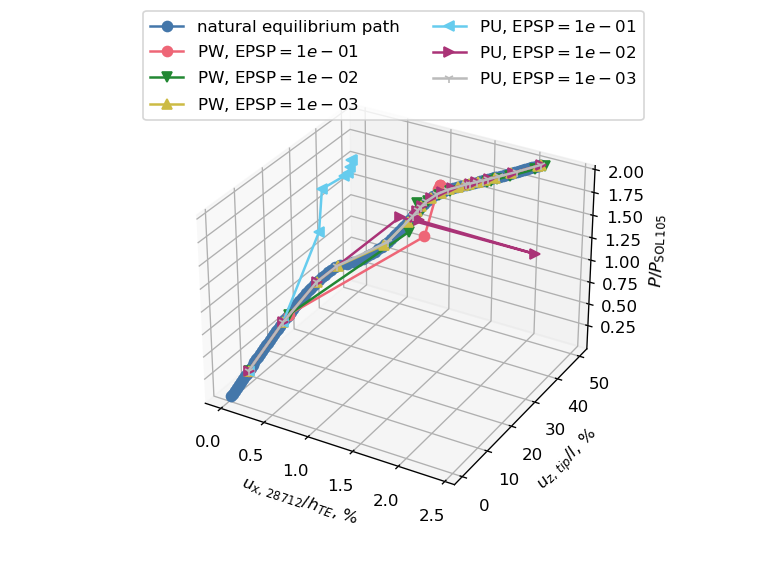

In [19]:
error_functions = ["PW", "PU"]
load_displacement_tolerances = [1e-1, 1e-2, 1e-3]
energy_tolerances = [1e-1, 1e-3, 1e-7]

ax = (
    plot_natural_equilibrium_path()
)  # create new figure and plot natural equilibrium path

# Run analysis for each set of error functions and plot load-displacement diagram
for fun_count, fun in enumerate(error_functions):
    ucrm9_bdf.nlparms[sensitivity_nlparm_id].conv = fun  # set error function
    for tol_count, tol in enumerate(load_displacement_tolerances):
        ucrm9_bdf.nlparms[sensitivity_nlparm_id].eps_p = tol  # set load tolerance
        ucrm9_bdf.nlparms[sensitivity_nlparm_id].eps_u = (
            tol  # set displacement tolerance
        )
        ucrm9_bdf.nlparms[sensitivity_nlparm_id].eps_w = energy_tolerances[
            tol_count
        ]  # set displacement tolerance
        input_name = "nonlinear_analysis_error_function_" + fun + f"_epsp{tol:.0e}"
        marker_index = fun_count * len(load_displacement_tolerances) + tol_count
        plot_3d_load_displacement_curve(
            ucrm9_bdf,
            input_name,
            ax,
            BUCKLING_LOAD_SCALE_FACTOR,
            MARKERS[marker_index],
            f"{fun}, $\mathrm{{EPSP}}={tol:.0e}$",
            run_flag=False,
        )

# Set plot appearance
ax.set_xlabel(f"$u_{{x,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/h_{{TE}}$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_\mathrm{SOL\/105}$")
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=2)
plt.grid()
plt.show()

The two analyses with the loosest convergence tolerances fail to converge to the prescribed applied load because the maximum number of bisections is reached. The analyses with intermediate convergence tolerances correspond to the analyses carried out for the error function sensitivity study, and present the jumps described earlier. All the equilibrium points of the analyses employing the tightest convergence tolerances fall on the natural equilibrium path, suggesting that by tightening the convergence tolerances the error function becomes less relevant to follow the natural equilibrium path.

The total number of arc-length increments is very similar for both analyses employing the tightest combination of tolerances, with 19 increments for the analysis with the load and displaceemnt error functions and 20 increments for the analysis with the load and energy error functions. This means that the arc-length solver achieves approximately the same resolution of the equilibrium path for both error functions. Since the analysis with the load and displacement error functions took less time to run, we select this combination of error functions and convergence tolerances and move on to the next parameter.

In [20]:
ucrm9_bdf.nlparms[sensitivity_nlparm_id].conv = "PU"  # set error function
ucrm9_bdf.nlparms[sensitivity_nlparm_id].eps_p = 1e-3  # set load tolerance
ucrm9_bdf.nlparms[sensitivity_nlparm_id].eps_u = 1e-3  # set displacement tolerance

### Initial arc-length increment

Now we consider three different values for the initial arc-length increment:

- $\Delta\mu^1=0.5$;
- $\Delta\mu^1=0.1$ (default);
- $\Delta\mu^1=0.01$.

Nastran job nonlinear_analysis_deltamu1_5e-01.bdf completed
Wall time: 518.0 s
Nastran job nonlinear_analysis_deltamu1_1e-01.bdf completed
Wall time: 609.0 s
Nastran job nonlinear_analysis_deltamu1_1e-02.bdf completed
Wall time: 670.0 s


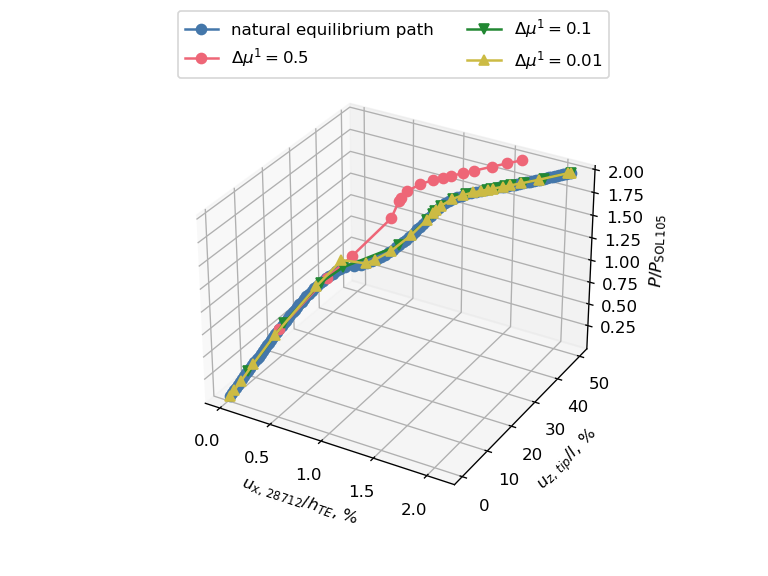

In [21]:
initial_increments = [0.5, 0.1, 0.01]
ucrm9_bdf.nlpcis[sensitivity_nlparm_id].mxinc = 100

ax = (
    plot_natural_equilibrium_path()
)  # create new figure and plot natural equilibrium path

# Run analysis for each set of error functions and plot load-displacement diagram
for count, delta_mu1 in enumerate(initial_increments):
    ucrm9_bdf.nlparms[sensitivity_nlparm_id].ninc = round(
        1 / delta_mu1
    )  # convert initial increment to prescribed number of increments
    input_name = f"nonlinear_analysis_deltamu1_{delta_mu1:.0e}"
    plot_3d_load_displacement_curve(
        ucrm9_bdf,
        input_name,
        ax,
        BUCKLING_LOAD_SCALE_FACTOR,
        MARKERS[count],
        f"$\Delta\mu^1={delta_mu1:.9g}$",
        run_flag=False,
    )

# Set plot appearance
ax.set_xlabel(f"$u_{{x,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/h_{{TE}}$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_\mathrm{SOL\/105}$")
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=2)
plt.grid()
plt.show()

For $P/P_\text{SOL 105}>1$, the analysis with $\Delta\mu^1=0.5$ converges to equilibrium points of a complementary path, while the other two analyses converge to the natural equilibrium path. However, the load-displacement curve obtained with $\Delta\mu^1=0.01$ does have one equilibrium point off the natural path at approximately $P/P_\text{SOL 105}=1.04$, meaning that the arc-length solver probably jumped to a complementary path and then back to the natural path.

Since the analysis with $\Delta\mu^1=0.1$ took less time to run, we select this value for the initial arc-length increment and move on to the next parameter.

In [22]:
ucrm9_bdf.nlparms[sensitivity_nlparm_id].ninc = round(1 / 0.1)

### Desired number of iterations

Now we investigate the influence of the desired number of iterations, using the following values:

- $I_d=20$;
- $I_d=12$ (default);
- $I_d=5$.

Nastran job nonlinear_analysis_desiter20.bdf completed
Wall time: 708.0 s
Nastran job nonlinear_analysis_desiter12.bdf completed
Wall time: 576.0 s
Nastran job nonlinear_analysis_desiter5.bdf completed
Wall time: 594.0 s


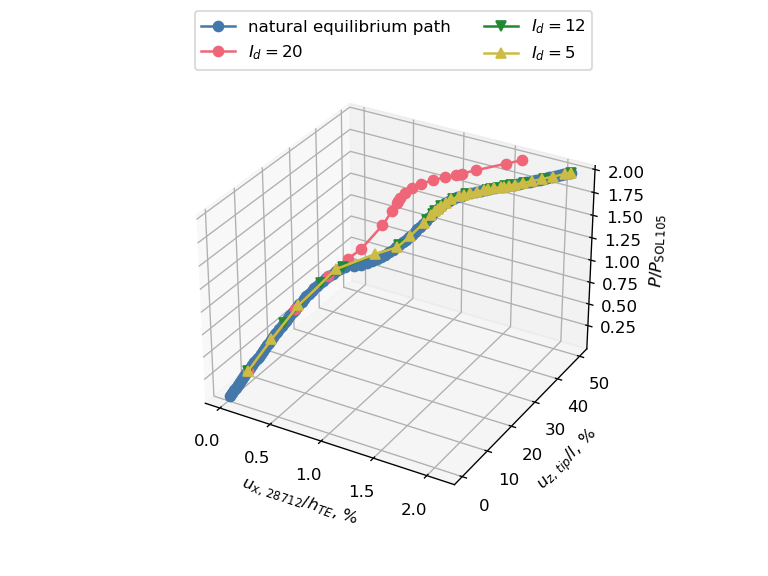

In [23]:
desired_no_iterations = [20, 12, 5]

ax = (
    plot_natural_equilibrium_path()
)  # create new figure and plot natural equilibrium path

# Run analysis for each set of error functions and plot load-displacement diagram
for count, desiter in enumerate(desired_no_iterations):
    ucrm9_bdf.nlpcis[sensitivity_nlparm_id].desiter = desiter
    input_name = f"nonlinear_analysis_desiter{desiter:d}"
    plot_3d_load_displacement_curve(
        ucrm9_bdf,
        input_name,
        ax,
        BUCKLING_LOAD_SCALE_FACTOR,
        MARKERS[count],
        f"$I_d={desiter:d}$",
        run_flag=False,
    )

# Set plot appearance
ax.set_xlabel(f"$u_{{x,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/h_{{TE}}$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_\mathrm{SOL\/105}$")
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=2)
plt.grid()
plt.show()

Similarly to the results of the sensitivity study on the initial arc-length increment, the analysis with $I_d=20$ appears to converge to a complementary path for $P/P_\text{SOL 105}>1$, while the other two analyses converge to the natural equilibrium path. However, the analysis employing $I_d=5$, which results in a more refined load-dispalcement curve, finds one equilibrium point off the natural path at approximately $P/P_\text{SOL 105}=1.15$, meaning that the arc-length solver probably jumped to a complementary path and then back to the natural path.

Since the analysis with $I_d=12$ took less time to run, we select this value for the desired number of iterations and move on to the next parameter.

In [24]:
ucrm9_bdf.nlpcis[sensitivity_nlparm_id].desiter = 12

### Minimum allowable arc-length adjustment ratio

Next, we assess the effect of the minimum allowable arc-length adjustment ratio, investigating three values:

- $\mathrm{MINALR}=0.9$;
- $\mathrm{MINALR}=0.25$ (default);
- $\mathrm{MINALR}=0.01$.

Nastran job nonlinear_analysis_minalr0_9.bdf completed
Wall time: 546.0 s
Nastran job nonlinear_analysis_minalr0_25.bdf completed
Wall time: 544.0 s
Nastran job nonlinear_analysis_minalr0_01.bdf completed
Wall time: 546.0 s


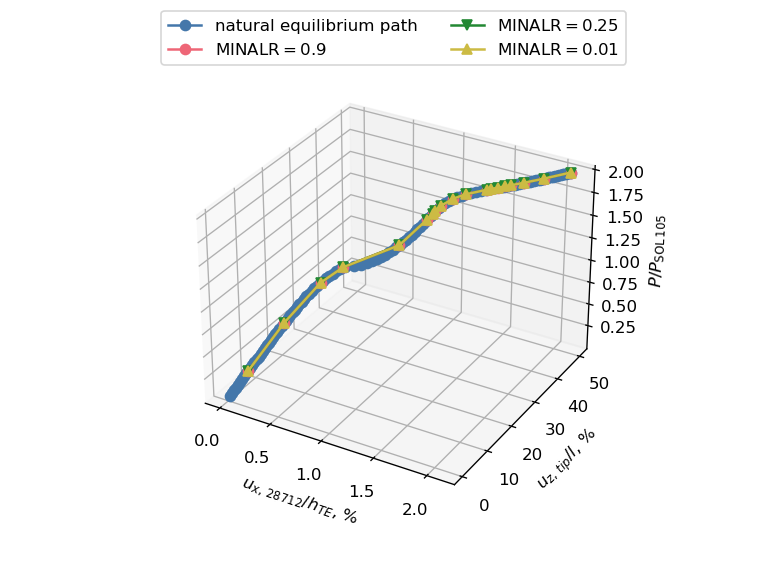

In [25]:
minimum_ratios = [0.9, 0.25, 0.01]

ax = (
    plot_natural_equilibrium_path()
)  # create new figure and plot natural equilibrium path

# Run analysis for each set of error functions and plot load-displacement diagram
for count, minalr in enumerate(minimum_ratios):
    ucrm9_bdf.nlpcis[sensitivity_nlparm_id].minalr = minalr
    input_name = f"nonlinear_analysis_minalr{minalr:.9g}".replace(".", "_")
    plot_3d_load_displacement_curve(
        ucrm9_bdf,
        input_name,
        ax,
        BUCKLING_LOAD_SCALE_FACTOR,
        MARKERS[count],
        f"$\mathrm{{MINALR}}={minalr:.9g}$",
        run_flag=False,
    )

# Set plot appearance
ax.set_xlabel(f"$u_{{x,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/h_{{TE}}$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_\mathrm{SOL\/105}$")
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=2)
plt.grid()
plt.show()

In this case we cannot see any effect on the load-displacement curve, so we switch back to the default value.

In [26]:
ucrm9_bdf.nlpcis[sensitivity_nlparm_id].minalr = 0.25

### Maximum allowable arc-length adjustment ratio

Finally, we consider four different maximum allowable arc-length adjustment ratios:

- $\mathrm{MAXALR}=8$;
- $\mathrm{MAXALR}=4$ (default);
- $\mathrm{MAXALR}=1.01$;
- $\mathrm{MAXALR}=1.0001$.

Nastran job nonlinear_analysis_maxalr8.bdf completed
Wall time: 552.0 s
Nastran job nonlinear_analysis_maxalr4.bdf completed
Wall time: 550.0 s
Nastran job nonlinear_analysis_maxalr1_01.bdf completed
Wall time: 996.0 s
Nastran job nonlinear_analysis_maxalr1_0001.bdf completed
Wall time: 807.0 s


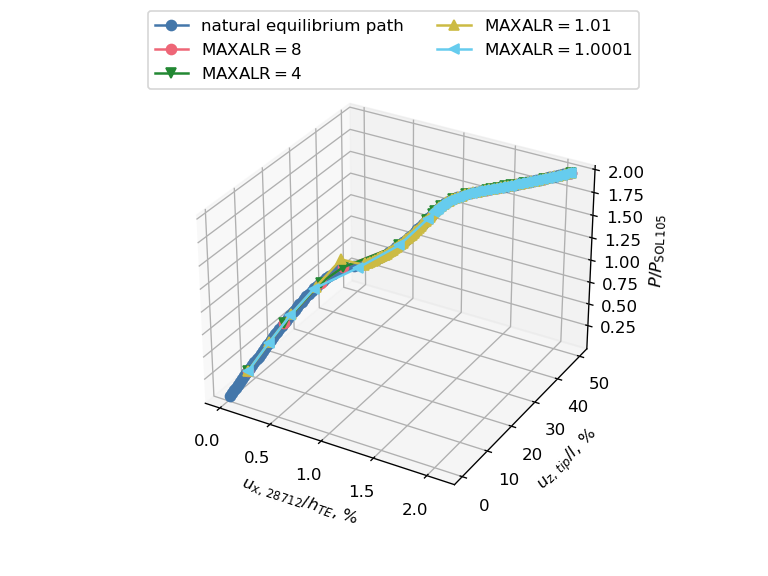

In [27]:
maximum_ratios = [8.0, 4.0, 1.01, 1.0001]

ax = (
    plot_natural_equilibrium_path()
)  # create new figure and plot natural equilibrium path

# Run analysis for each set of error functions and plot load-displacement diagram
for count, maxalr in enumerate(maximum_ratios):
    ucrm9_bdf.nlpcis[sensitivity_nlparm_id].maxalr = maxalr
    input_name = f"nonlinear_analysis_maxalr{maxalr:.9g}".replace(".", "_")
    plot_3d_load_displacement_curve(
        ucrm9_bdf,
        input_name,
        ax,
        BUCKLING_LOAD_SCALE_FACTOR,
        MARKERS[count],
        f"$\mathrm{{MAXALR}}={maxalr:.9g}$",
        run_flag=False,
    )

# Set plot appearance
ax.set_xlabel(f"$u_{{x,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/h_{{TE}}$, %")
ax.set_ylabel("$u_{z,\,tip}/l$, %")
ax.set_zlabel("$P/P_\mathrm{SOL\/105}$")
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", ncol=2)
plt.grid()
plt.show()

Almost all equilibrium points found by all analyses fall on the natural equilibrium path, with the exception of a couple of points resulting from the analyses with $\mathrm{MAXALR}=1.01$ and $1.0001$, between $P/P_\text{SOL 105}=1.02$ and $P/P_\text{SOL 105}=1.06$. Similarly to the previous cases, this probably means that the arc-length solver jumped to a complementary path and then back to the natural path.

What is interesting to notice in the plot above is that, in the analyses with the smallest maximum arc-length ratio, the resolution of the load-displacement curve increases significantly after a certain point. This happens because the solver encounters a highly nonlinear segment of the natural equilibrium path and is forced to bisect the arc-lenth increment a number of times. Since the maximum arc-length ratio is close to $1$, meaning constant increments, the increments can grow only very slowly, practically keeping the resolution of the curve very high for the rest of the analysis. However, the increased resolution of the load-displacement curve does not seem to be necessary to capture the natural equilibrium path, and considering the increased computational cost, we decide to switch back to the default value.

In [28]:
ucrm9_bdf.nlpcis[sensitivity_nlparm_id].maxalr = 4.0

## Nonlinear analysis: complementary equilibrium paths <a name="complementary-paths"></a>

***

Now we want to investigate the presence of complmementary paths in the equilibrium manifold of the uCRM-9. In our previous notebooks on the different box beam configurations, we ran a series of nonlinear analyses using a coarse arc-length increment and different nonlinear analysis parameters, with the aim of letting the arc-length solver jump from the natural path to a complementary path. Then we unloaded the structure from the final equilibrium point of the complementary path using fine arc-length increments in order to trace it accurately.

In this notebook we have run a sensitivity study on the nonlinear analysis parameters with a limited number of allowed iterations for each increment, with the idea of preventing the solver from jumping from one equilibrium path to another. Nevertheless, we have still observed the convergence of the arc-length solver to a complementary path for some combinations of parameters, as in the case of a large initial increment or a large number of desired iterations.

For this reason we are going to unload the structure form the final equilibrium point of the analysis employing an initial arc-length increment of $0.5$ and trace the corresponding complementary path. We start by modifying the `NLPARM` and `NLPCI` cards of the first subcase.

In [29]:
ucrm9_bdf.nlparms[sensitivity_nlparm_id].ninc = round(1 / 0.5)

Then we create a second subcase with zero applied load. We assign the `NLPARM` card with fine arc-length increments to the second subcase, lowering the maximum number of arc-length increments from 1000 to 200 to avoid long computation times.

In [30]:
ucrm9_bdf.add_load(
    ZERO_LOAD_SET_ID, scale=1.0, scale_factors=[0.0], load_ids=[force_id]
)  # add LOAD card with zero applied load
SECOND_SUBCASE_ID = 2  # id of second subcase
pynastran_utils.create_static_load_subcase(
    bdf=ucrm9_bdf, subcase_id=SECOND_SUBCASE_ID, load_set_id=ZERO_LOAD_SET_ID
)  # create subcase with zero applied load
fine_increments_nlparm_id = (
    1  # id of the NLPRM card defining the fine arc-length increments
)
ucrm9_bdf.case_control_deck.subcases[SECOND_SUBCASE_ID].params["NLPARM"][
    0
] = fine_increments_nlparm_id  # set NLPARM case control parameter of second subcase to card with fine increments
ucrm9_bdf.nlpcis[fine_increments_nlparm_id].mxinc = (
    200  # reduce maximun number of increments to 200
)

In this way, we have defined a nonlinear analysis with the following subcases:

1. pseudo-aerodynamic load, load and displacement error functions, default remaining parameters except for:
   - $\mathrm{EPSU}=\mathrm{EPSP}=10^{-3}$;
   - $\Delta\mu^1=0.5$;
   - $\mathrm{MAXITER}=5$;
2. zero load, load and displacement error functions with vector component checking, fine arc-length increments:
   - $\Delta\mu^1=0.01$;
   - $\mathrm{MAXITER}=5$;
   - $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$;
   - $\mathrm{MAXBIS}=10$;
   - $\mathrm{MINALR}=0.01$;
   - $\mathrm{MAXALR}=1.0001$;
   - $\mathrm{DESITER}=5$;
   - $\mathrm{MXINC}=200$.

After running the analysis, want to visualize the results of our analysis in terms of the 3D equilibrium path of each subcase. To do this, we define the function `plot_3d_equilibrium_path`, which creates a new figure with a 3D axis and plots first the natural equilibrium path and then the paths found in the different subcases. To visualize the corresponding tangent stiffness matrix eigenvalues, we define the function `plot_eigenvalue_diagram`, which plots the eigenvalues of the tangent stiffness matrix of each subcase against the applied load, which is nondimensionalized with respect to the magnitude of the critical buckling load predicted by SOL 105.

In [31]:
SOL_105_BUCKLING_LOAD_MAGNITUDE = (
    np.linalg.norm(
        np.sum(sol_105_op2.load_vectors[FIRST_SUBCASE_ID].data[0, :, 0:3], axis=0)
    )
    * sol_105_buckling_factor
)  # find overall linear buckling load magnitude - needed to nondimensionalize the applied load


def plot_3d_equilibrium_diagram(loads, local_disp, tip_disp):
    # Plot natural equilibrium path
    ax3d = plot_natural_equilibrium_path()
    # Plot 3D equilibrium paths of last analysis
    for subcase_id in loads:
        ax3d.plot(
            local_disp[subcase_id][:, X_COMPONENT_INDEX] / H_TE * 100,
            tip_disp[subcase_id][:, Z_COMPONENT_INDEX] / L * 100,
            np.linalg.norm(loads[subcase_id], axis=1) / SOL_105_BUCKLING_LOAD_MAGNITUDE,
            marker=MARKERS[subcase_id],
            label=f"Subcase {subcase_id:d}",
        )
    # Set plot appearance
    ax3d.set_xlabel(f"$u_{{x,\,{MAX_DISPLACEMENT_NODE_ID:d}}}/h_{{TE}}$, %")
    ax3d.set_ylabel("$u_{z,\,tip}/l$, %")
    ax3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center")
    plt.grid()
    plt.show()


def plot_eigenvalue_diagram(filename, loads):
    # Plot eigenvalue diagram
    f06_path = os.path.join(
        ANALYSIS_DIRECTORY_PATH, filename + ".f06"
    )  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey="all")
    iterations_count = 1
    # Divide lowest eigenvalues by subcase and plot them
    eigvals_count = 0
    eigvals_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigvals_by_subcase[subcase] = eigvals[
            :, eigvals_count : eigvals_count + no_load_steps
        ]
        eigvals_count += no_load_steps
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(
            np.arange(
                iterations_count,
                eigvals_by_subcase[subcase].shape[1] + iterations_count,
            ),
            eigvals_by_subcase[subcase].T * 1e3,
            MARKERS[subcase],
            color=COLORS[subcase],
            label=f"Subcase {subcase:d}",
        )
        iterations_count += eigvals_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(
            np.linalg.norm(
                loads[subcase][: eigvals_by_subcase[subcase].shape[1], 0:3], axis=1
            )
            / SOL_105_BUCKLING_LOAD_MAGNITUDE,
            eigvals_by_subcase[subcase].T * 1e3,
            MARKERS[subcase],
            color=COLORS[subcase],
        )
    # Set plot appearance
    eigvals_axs[0].set_xlabel("increment number")
    eigvals_axs[0].set_ylabel("$\lambda$, N/m")
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel("$P/P_\mathrm{SOL\/105}$")
    eigvals_axs[1].grid(visible=True)
    plt.show()

We finally run the analysis and plot our results.

Nastran job equilibrium_path_verification_deltamu1_5e-01.bdf completed
Wall time: 5183.0 s


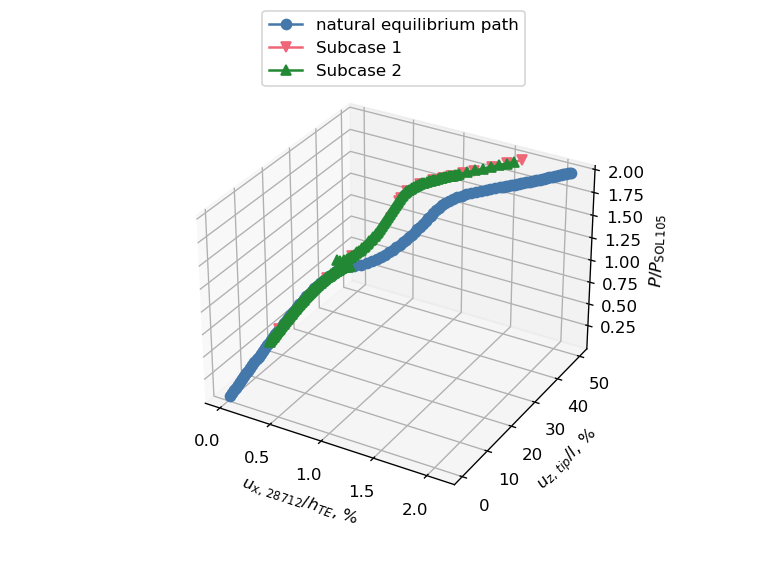

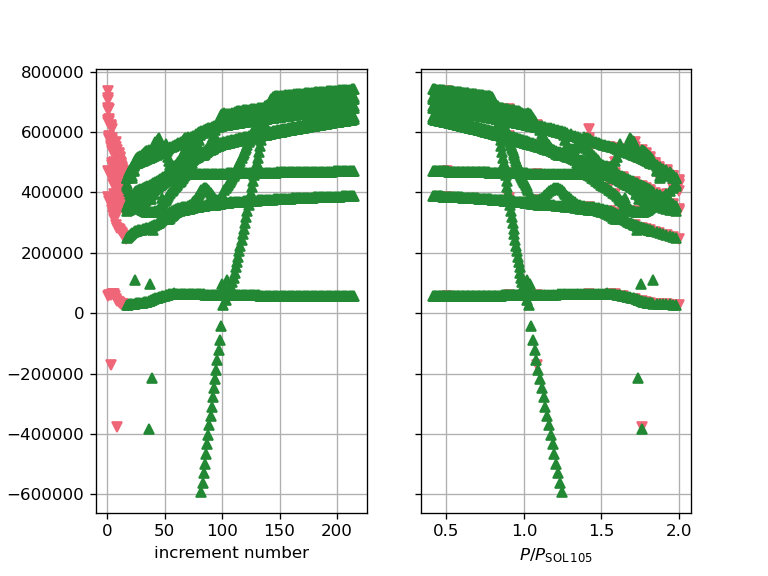

In [32]:
# Run analysis
input_name = "equilibrium_path_verification_deltamu1_5e-01"
upper_eigenvalue = 1e4  # upper bound for eigenvalues [N/mm] - set to 10^7 N/m to avoid convergence issues of Lanczos solver
lower_eigenvalue = (
    -1e4
)  # lower bound for eigenvalues [N/mm] - set to -10^7 N/m to avoid convergence issues of Lanczos solver
sol_106_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=ucrm9_bdf.__deepcopy__({}),
    method_set_id=METHOD_SET_ID,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    no_eigenvalues=no_eigenvalues,
    upper_eig=upper_eigenvalue,
    lower_eig=lower_eigenvalue,
    run_flag=False,
)

# Read load and displacement history from the op2 file
_, applied_loads, displacements_dict = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[TIP_NODE_ID, MAX_DISPLACEMENT_NODE_ID]
    )
)
tip_displacements = displacements_dict[TIP_NODE_ID]
local_displacements = displacements_dict[MAX_DISPLACEMENT_NODE_ID]

# Plot results
plot_3d_equilibrium_diagram(applied_loads, local_displacements, tip_displacements)
plot_eigenvalue_diagram(input_name, applied_loads)

The results of the analysis show that, in the second subcase, the arc-length solver initially follows the complementary path and when approaching $P/P_\text{SOL 105}=1$ it jumps to the natural path. However, zooming in the load-displacement plot, it is possible to notice that the jump does not happen directly between the two paths, but the solver finds a few equilibrium points in between that do not seem to belong to the main complementary path nor to the natural path.

Looking at the eigenvalue diagram, it is possible to notice that the segment of the complementary path initially followed by the solver is unstable, as one negative eigenvalue emerges from $P/P_\text{SOL 105}=1.24$. This negative eigenvalue is likely to be present also at higher load levels, however given the probable larger magnitude is not found within the 10 smallest-magnitude eigenvalues of the tangetn stiffness matrix. In addition, at higher load levels, we can observe the presence of a few isolated eigenvalues, but it is difficult to ascertain whether they correspond to small jumps from the main complementary path or to points of unresolved eigenvalue curves.

What is interesting to notice is that the negative eigenvalue points toward zero for decreasing applying load, and following the complementary path we would expect it to transition to a positive value, thus indicating the stable segment of the path. However, after the first converged increment where the eigenvalue appears to have become positive, we observe a strange behavior of the same eigenvalue, as it appears to decrease and increase alternately for a few increments, before permanently increasing as the solver has jumped on the natural path and the structure is further unloaded. This alternating decrease and increase of the mentioned eigenvalue occurs at the same load level where we observe the first jump and the successive intermediate equilibrium points between the main complementary path and the natural path. For this reason, we look in the f06 the convergence statistics of the arc-length increment where the eigenvalue becomes positive.

```raw
0                             N O N - L I N E A R   I T E R A T I O N   M O D U L E   O U T P U T

     STIFFNESS UPDATE TIME          3.16 SECONDS                                                               SUBCASE        2
            ITERATION TIME          0.14 SECONDS                                                        LOAD FACTOR   0.4798779

                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         2  7.5896E-04  1.2562E-05  1.3869E-07  1.0000E-01  7.9351E-02  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6186 (NCONVG)
     *** SOLUTION HAS CONVERGED ***
         SUBID    2     LOOPID  100     LOAD STEP    1.480     LOAD FACTOR 0.47987791
```

The convergence statistics show that the increment converged in $2$ iterations with a displacement error of about $7.6\cdot10^{-4}$ and an energy error of about $1.3\cdot10^{-5}$. In order to force the solver to bisect this increment, we repeat the analysis setting $\mathrm{MAXITER}=2$, $\mathrm{EPSU}=\mathrm{EPSP}=10^{-4}$. Furthermore, to visualize the curve of the negative eigenvalue throughout the whole analysis, we decrease the upper bound of the monitored eigenvalues from $10^7$ to $5\cdot10^5$ N/m and we increase the number of monitored eigenvalues from $10$ to $20$.

Nastran job equilibrium_path_verification_deltamu1_5e-01_maxiter2.bdf completed
Wall time: 765.0 s


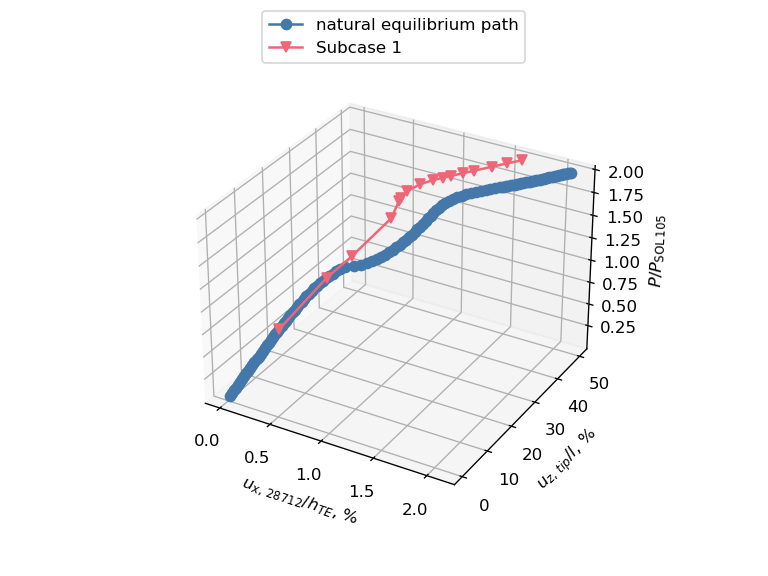

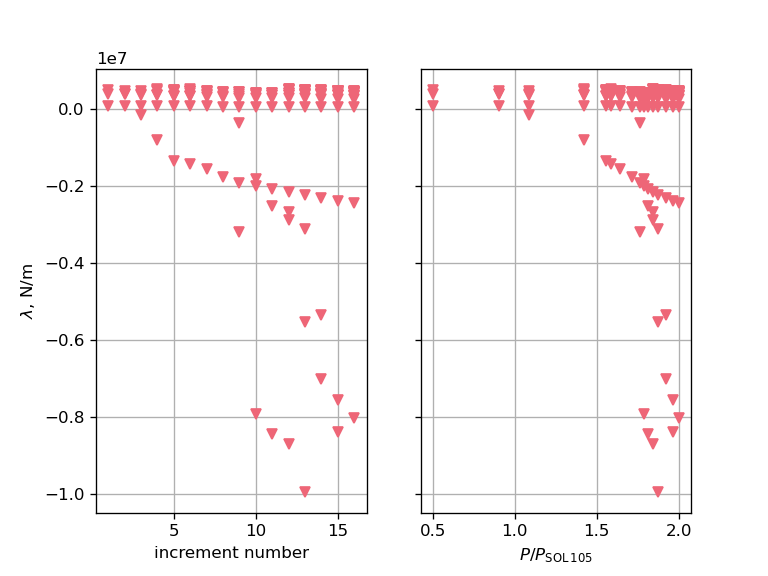

In [33]:
# Modify parameters
ucrm9_bdf.nlparms[fine_increments_nlparm_id].max_iter = (
    2  # set maximum number of iterations
)
ucrm9_bdf.nlparms[fine_increments_nlparm_id].esp_u = (
    1e-4  # set displacement convergence tolerance
)
ucrm9_bdf.nlparms[fine_increments_nlparm_id].esp_p = (
    1e-4  # set load convergence tolerance
)
upper_eigenvalue = 5e2  # upper bound for eigenvalues [N/mm] - set to 5*10^5 N/m to visualize curve of negative eigenvalue
no_eigenvalues = 20  # number of eigenvalues to be calculated

# Run analysis
input_name = "equilibrium_path_verification_deltamu1_5e-01_maxiter2"
sol_106_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=ucrm9_bdf.__deepcopy__({}),
    method_set_id=METHOD_SET_ID,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    no_eigenvalues=no_eigenvalues,
    upper_eig=upper_eigenvalue,
    lower_eig=lower_eigenvalue,
    run_flag=False,
)

# Read load and displacement history from the op2 file
_, applied_loads, displacements_dict = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[TIP_NODE_ID, MAX_DISPLACEMENT_NODE_ID]
    )
)
tip_displacements = displacements_dict[TIP_NODE_ID]
local_displacements = displacements_dict[MAX_DISPLACEMENT_NODE_ID]

# Plot results
plot_3d_equilibrium_diagram(applied_loads, local_displacements, tip_displacements)
plot_eigenvalue_diagram(input_name, applied_loads)

The analysis fails at the beginning of the second subcase because of a regression to an earlier load step occurring with both root-selection algorithms of Crisfield's method. Looking at the f06 file we actually observe that, after bisecting the first attempted increment, the solver tries to apply negative arc-length increments for the remainder of the analysis, it achieves convergence once and then the analysis fails because of the mentioned error.

Looking further into this issue and after trying a few analyses, we've found out that the application of negative increments occurs consistently when the first increment does not converge at the first attempt and is bisected. When the first increment converges at the first attempt, the negative increments are not applied and the analysis proceeds normally.

This issue is most probably related to a bug in SOL 106 and it puts a limit to the maximum number of iterations and to the convergence tolerances that we can use when unloading the structure in the second subcase. The tightest combination of maximum number of iterations and convergence tolerances that we can use is determined by the residuals calculated at the end of the first convergence attempt, before the bisection takes place. Looking into the f06 file we find the following results before the bisection is performed:

```raw
0                             N O N - L I N E A R   I T E R A T I O N   M O D U L E   O U T P U T

     STIFFNESS UPDATE TIME          3.34 SECONDS                                                               SUBCASE        2
            ITERATION TIME          0.14 SECONDS                                                        LOAD FACTOR   0.0099961

                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         2  1.3506E-02  4.6599E-04  1.0671E-07  1.0000E-01  4.0221E-01  1.0000E+00  3.5751E-04  3.5751E-04    0    0          0    1
 *** USER INFORMATION MESSAGE 6194 (NCONVG)
     *** STOPPED ITERATIONS DUE TO REACHING MAXIMUM ITERATION LIMIT WITHOUT CONVERGENCE ***
 *** USER INFORMATION MESSAGE 6187 (NCONVG)
     *** BISECTION METHOD IS NOW ACTIVATED ***
```

The displacement and error functions after two iterations are respectively about $\mathrm{EPSU}=1.4\cdot10^{-2}$ and $\mathrm{EPSP}=4.7\cdot10^{-4}$. However, these convergence tolerances would be too loose to guarantee that arc-length increments close to $P/P_\text{SOL 105}=1$ are bisected as much as needed to prevent the solver from jumping from the complementary path. For this reason, we look back at the convergence statistics of the same increment for our previous analysis with $\Delta\mu^1=0.5$:

```raw
0                             N O N - L I N E A R   I T E R A T I O N   M O D U L E   O U T P U T

     STIFFNESS UPDATE TIME          3.12 SECONDS                                                               SUBCASE        2
            ITERATION TIME          0.14 SECONDS                                                        LOAD FACTOR   0.0099941

                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         3  1.6538E-04  1.0809E-05  1.4198E-10  1.0000E-01  1.6395E-02  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6186 (NCONVG)
     *** SOLUTION HAS CONVERGED ***
         SUBID    2     LOOPID   17     LOAD STEP    1.010     LOAD FACTOR 0.00999410
```

In that case, the first increment of the second subcase converged in 3 iterations, with a displacement error of about $1.65\cdot10^{-4}$ and a load error of about $1.08\cdot10^{-5}$. We cannot be sure whether these convergence tolerances would be tight enough to prevent the solver from jumping from the complementary path, however we can try to use them in the second subcase and see what happens. For this reason, we set $\mathrm{MAXITER}=3$, $\mathrm{EPSU}=1.7\cdot 10^{-4}$, $\mathrm{EPSP}=1.1\cdot 10^{-5}$ for a new run of the analysis. We also decrease the lower bound of the monitored eigenvalues from $10^{-7}$ to $10^{-8}$ N/m, as in the last analysis the eigenvalue diagram showed a few eigenvales close to the lower bound.

Nastran job equilibrium_path_verification_deltamu1_5e-01_maxiter3.bdf completed
Wall time: 4393.0 s


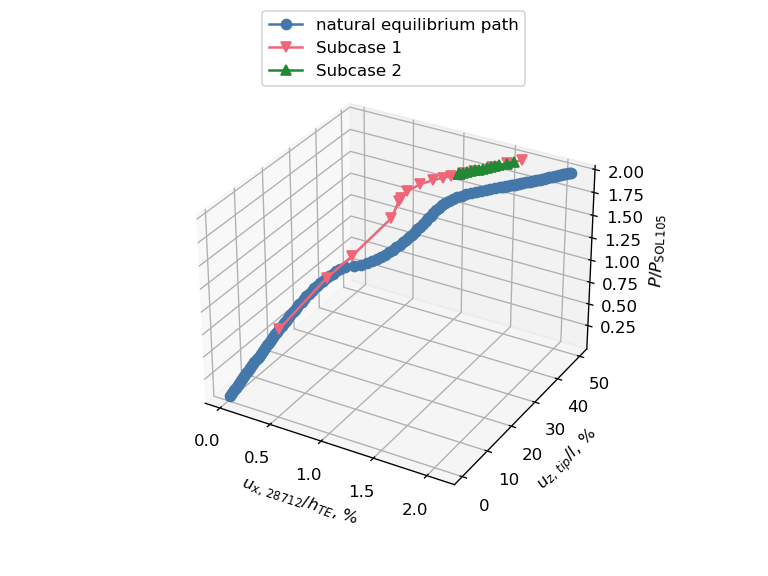

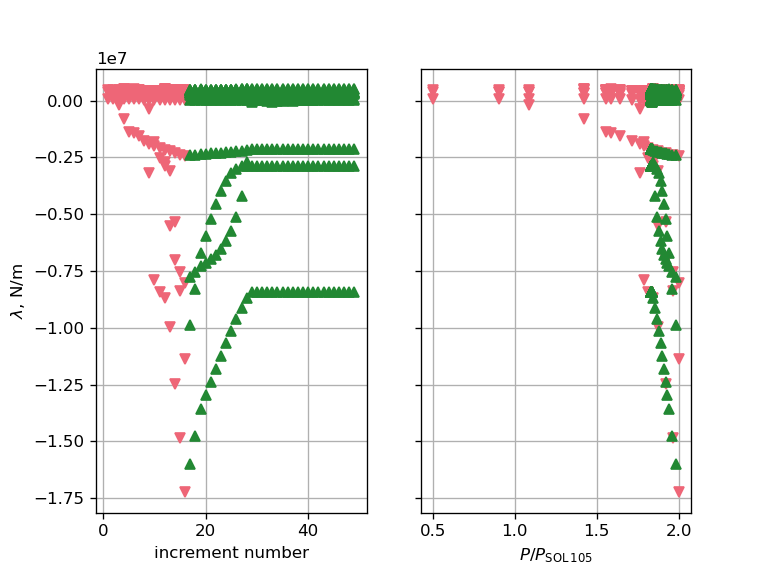

In [34]:
# Modify parameters
ucrm9_bdf.nlparms[fine_increments_nlparm_id].max_iter = (
    3  # set maximum number of iterations
)
ucrm9_bdf.nlparms[fine_increments_nlparm_id].eps_u = (
    1.7e-4  # set displacement convergence tolerance
)
ucrm9_bdf.nlparms[fine_increments_nlparm_id].eps_p = (
    1.1e-5  # set load convergence tolerance
)
ucrm9_bdf.nlparms[fine_increments_nlparm_id].max_bisect = (
    20  # set maximum number of bisections
)
lower_eigenvalue = (
    -1e5
)  # lower bound for eigenvalues [N/mm] - set to -10^8 N/m to visualize curves of negative eigenvalues

# Run analysis
input_name = "equilibrium_path_verification_deltamu1_5e-01_maxiter3"
sol_106_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf=ucrm9_bdf.__deepcopy__({}),
    method_set_id=METHOD_SET_ID,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    no_eigenvalues=no_eigenvalues,
    upper_eig=upper_eigenvalue,
    lower_eig=lower_eigenvalue,
    run_flag=False,
)

# Read load and displacement history from the op2 file
_, applied_loads, displacements_dict = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[TIP_NODE_ID, MAX_DISPLACEMENT_NODE_ID]
    )
)
tip_displacements = displacements_dict[TIP_NODE_ID]
local_displacements = displacements_dict[MAX_DISPLACEMENT_NODE_ID]

# Plot results
plot_3d_equilibrium_diagram(applied_loads, local_displacements, tip_displacements)
plot_eigenvalue_diagram(input_name, applied_loads)

Now we can clearly see that the segment of the complementary path where the first subcase converges is unstable, as there are four negative eigenvalues. In the second subcase, the arc-length solver follows the complementary path towards decreasing load levels, until the analysis fails around $P/P_\text{SOL 105}=1.83$ because the maximum number of bisections or the minimum arc-length increment is reached. Zooming the eigenvalue diagram in the region of the positive eigenvalues, we can observe a cluster of eigenvalues depicting an eigenvalue curve crossing zero almost vertically at the load level where the analysis fails. This eigenvalue curve is most likely associated to a load limit point. However, looking at the eigenvalue vs increment number plot, we can see that the arc-length solver actually struggles to follow the path smoothly, as it shows alternating positive and negative eigenvalues instead of a monotonic decrease. This behavior is probably due to an extremely nonlinear segment of the complementary path, which forces the solver to bisect the arc-length increment beyond the minimum allowable value.

Given the above results, we decide not to pursue the investigation on the complementary paths of the uCRM-9 any further, as the portion of the equilibrium manifold under investigation appears too complex for the arc-length solver implementation of Nastran SOL 106. Nevertheless, we decide to plot the deformation of the uCRM-9 on the complementary path at $/P/P_\text{SOL 105}=2$ to compare it with the deformation on the natural path that we visualized earlier.

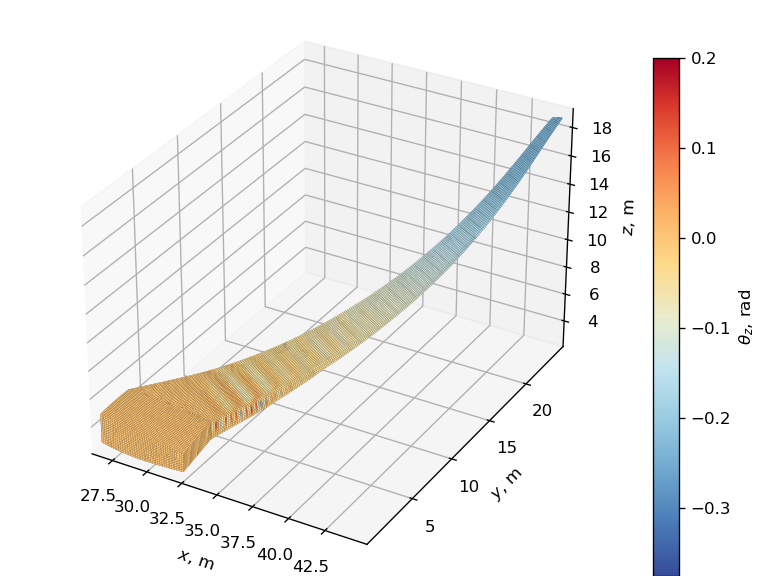

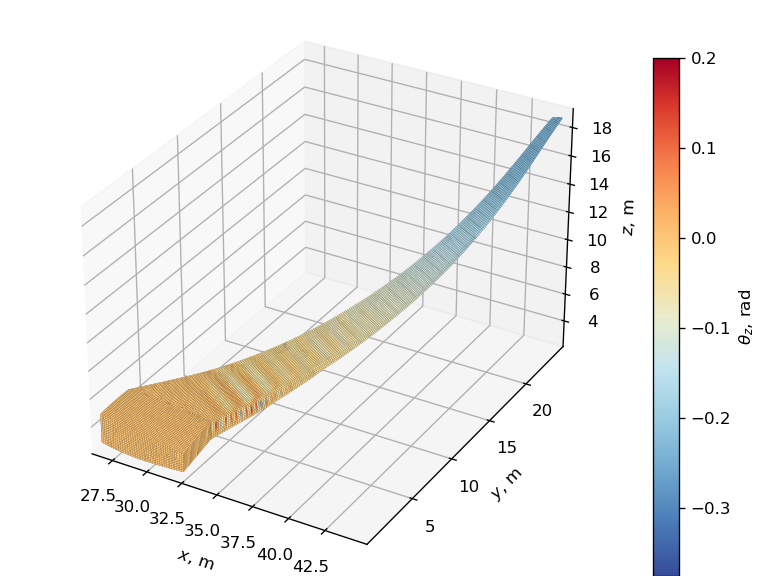

c:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\resources\plot_utils.py:584: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


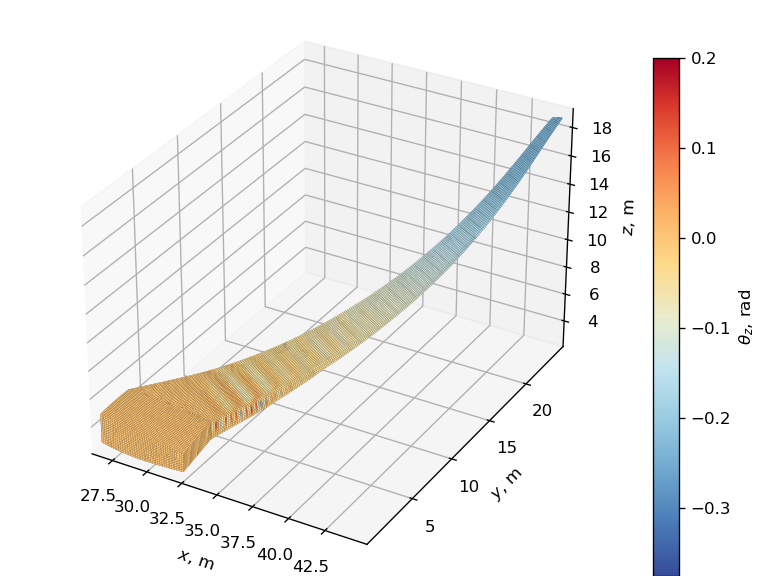

In [35]:
for op2 in ["rx", "ry", "rz"]:
    _, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_op2,
        displacement_component=component,
        colormap="sunset",
    )
    ax.locator_params(axis="x", nbins=8)  # set number of ticks of z-axis
    cbar.ax.set_position(
        cbar.ax.get_position().shrunk(1.0, 0.9)
    )  # decrease colorbar size
    plt.show()  # show plot

It is difficult to compare the deformed shapes of the structure on the natural and complementary paths, as the deformations look very similar. This similarity suggests that the two equilibrium points are very close within the equilibrium manifold of the uCRM-9, even if in the previous load-displacement diagram the points belonging to the natural and to the complementary paths could be clearly distinguished.

Nevertheless, we can spot a few differences by zooming in the rear spar region close to the kink and visualizing the rotation of the elements around the $z$ axis.

Natural path:


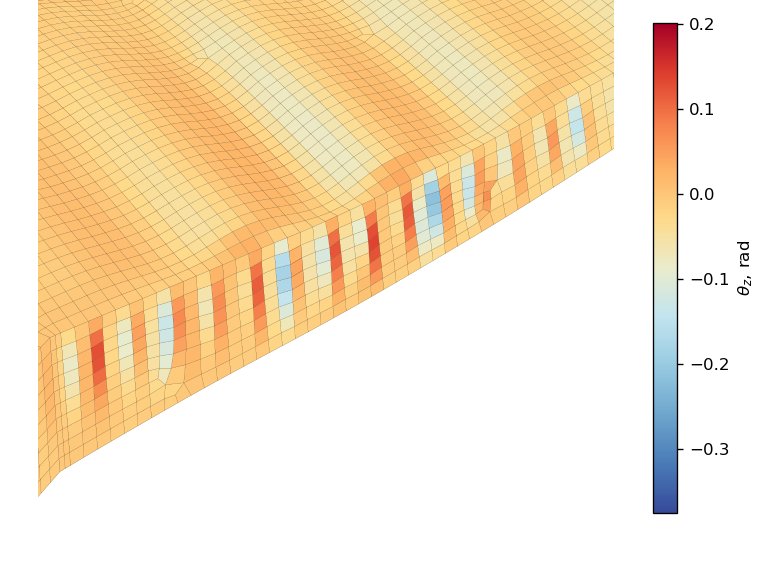

Complementary path:


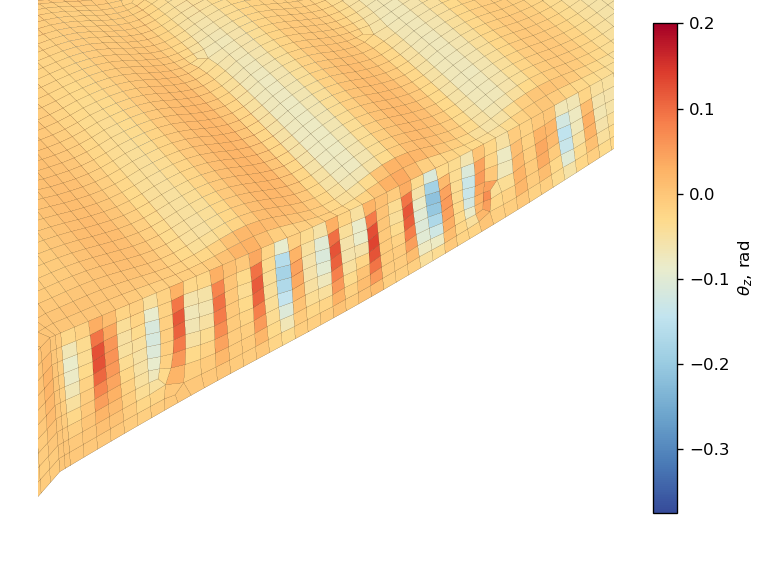

In [36]:
op2_dict = {
    "Natural path:": sol_106_natural_path_op2,
    "Complementary path:": sol_106_op2,
}
for key in op2_dict:
    print(key)
    _, ax, cbar = plot_utils.plot_deformation(
        op2=op2_dict[key],
        displacement_component="rz",
        colormap="sunset",
    )
    ax.locator_params(axis="x", nbins=8)  # set number of ticks of z-axis
    cbar.ax.set_position(
        cbar.ax.get_position().shrunk(1.0, 0.85)
    )  # decrease colorbar size
    cbar.ax.set_position(
        cbar.ax.get_position().translated(0, 0.11)
    )  # move colorbar upwards
    ax.set_xlim(31.0, 35.0)  # set x-axis limits
    ax.set_ylim(5.0, 7.5)  # set y-axis limits
    ax.set_zlim(3.0, 4.0)  # set z-axis limits
    ax.set_box_aspect(
        [ub - lb for lb, ub in (getattr(ax, f"get_{a}lim")() for a in "xyz")]
    )  # set aspect ratio
    plt.axis("off")  # turn off axis
    plt.show()  # show plot

From the above plots we can more easily notice the small differences between the deformed shapes of the rear spar on the natural and complementary paths.

## Nonlinear analysis: nonlinear buckling method verification <a name="nonlinear-buckling-method-verification"></a>

***

Now we are going to verify the results of SOL 106's nonlinear buckling method on the uCRM-9. This means that we are going to assess whether the nonlinear buckling method is able to predict the same critical load as SOL 105 for the initial linear range of the structural response. Besides,we are also going to investigate how the results change in the nonlinear range.

Similarly to what we did in our previous notebooks, we define 11 load magnitudes equally spaced between 0 and twice the linear buckling load. We discard the load case with null magnitude, we keep the other 10 load cases and define the corresponding subcases.

In [37]:
# Define and print the sequence of increasing applied loads
load_scale_factors = np.linspace(0, BUCKLING_LOAD_SCALE_FACTOR, 11)[1:]
np.set_printoptions(precision=2, suppress=True)
print(f"Applied loads factors (P/P_SOL 105): {load_scale_factors}")

# Create new LOAD card for first two subcases and assign LOAD card id to the control deck of each subcase
load_nlbuckling_set_id = ZERO_LOAD_SET_ID + 1  # id of the next LOAD card
for i, scale_factor in enumerate(load_scale_factors[:2]):
    ucrm9_bdf.add_load(
        sid=load_nlbuckling_set_id,
        scale=1.0,
        scale_factors=[sol_105_buckling_factor * load_scale_factors[i]],
        load_ids=[force_id],
    )  # create new LOAD card
    ucrm9_bdf.subcases[i + 1].params["LOAD"][
        0
    ] = load_nlbuckling_set_id  # assign LOAD card id to the control deck of existing subcase
    load_nlbuckling_set_id += 1  # increment LOAD card id

# Create LOAD card and corresponding subcases for remaining applied loads
for i, scale_factor in enumerate(load_scale_factors[2:], start=2):
    ucrm9_bdf.add_load(
        sid=load_nlbuckling_set_id,
        scale=1.0,
        scale_factors=[sol_105_buckling_factor * load_scale_factors[i]],
        load_ids=[force_id],
    )  # create new LOAD card
    pynastran_utils.create_static_load_subcase(
        bdf=ucrm9_bdf, subcase_id=i + 1, load_set_id=load_nlbuckling_set_id
    )  # create subcase with defined load set
    load_nlbuckling_set_id += 1  # increment LOAD card id

Applied loads factors (P/P_SOL 105): [0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]


Before running our analysis we assign the `NLPARM` card id of the sensitivity study to the global control deck (so that all subcases are run with the parameters defined by this card) and we restore the default value for the initial arc-length increment.

In [38]:
ucrm9_bdf.case_control_deck.subcases[0].params["NLPARM"][
    0
] = sensitivity_nlparm_id  # set global NLPARM case control parameter
ucrm9_bdf.nlparms[sensitivity_nlparm_id].ninc = round(
    1 / 0.1
)  # restore default initial arc-length increment

We run the analysis with SOL 106's nonlinear buckling method by calling the function `run_nonlinear_buckling_method` from the `pynastran_utils` module, which takes care of adding the necessary parameters to apply the nonlinear buckling method and executes Nastran.

In [39]:
method_nlbuckling_set_id = load_nlbuckling_set_id  # id of the next METHOD card
input_name = "nonlinear_buckling_method_verification"
sol_106_op2 = pynastran_utils.run_nonlinear_buckling_method(
    bdf=ucrm9_bdf,
    method_set_id=method_nlbuckling_set_id,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
    input_name=input_name,
    run_flag=False,
)

Nastran job nonlinear_buckling_method_verification.bdf completed
Wall time: 965.0 s


The analysis fails after the convergence of the last subcase because it could not compute the eigenvalue sought by the nonlinear buckling method. As a consequence, the nonlinear buckling factor is calculated for the first 9 load cases only.

We would now like to plot the nonlinear buckling loads against the applied loads, however we can use the function `read_nonlinear_buckling_load_from_f06` from the `pynastran_utils` module to read only the critical buckling factors from the f06 file, and not the nonlinear buckling loads, as the load vectors have not been written to the op2 file.

The nonlinear buckling load $P_\text{SOL 106}$ is calculated by Nastran in the following way:

$$\boldsymbol{P_\text{SOL 106}}=\boldsymbol{P_n}+\alpha\boldsymbol{\Delta P},$$

where $\boldsymbol{P_n}$ is the vector of the applied loads of the subcase, $\alpha$ is the critical buckling factor and $\boldsymbol{\Delta P}$ is the last load increment vector applied in the subcase.

We know the applied loads in each subcase and we can read the critical buckling factors with the function `read_nonlinear_buckling_load_from_f06`. By reading in the f06 file the last load increment applied in each subcase, we can calculate the nonlinear buckling loads and plot these against the applied loads.

In [40]:
# Read critical buckling factors from f06 file
f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + ".f06")
_, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(
    f06_filepath=f06_filepath, op2=sol_106_op2
)

# Read converged load factors from f06 file
load_factors_dict = {}  # dictionary to store converged load factors
with open(f06_filepath) as f06_file:  # open f06 file
    for line in f06_file:  # read line by line
        if "SUBID" in line:  # find line with subcase id
            subid = int(line.split()[1])  # read subcase id
            load_factor = float(line.split()[9])  # read converged load factor
            if subid not in load_factors_dict:  # create empty list for each subcase id
                load_factors_dict[subid] = []
            load_factors_dict[subid].append(
                load_factor
            )  # append converged load factor to the list

# Calculate nonlinear buckling loads
nondimensional_nonlinear_buckling_loads = np.zeros_like(
    critical_buckling_factors
)  # array to store nonlinear buckling loads nondimensionalized by linear buckling load
for i, alpha in enumerate(critical_buckling_factors):
    nondimensional_nonlinear_buckling_loads[i] = load_scale_factors[i] * (
        1 + alpha * (load_factors_dict[i + 1][-1] - load_factors_dict[i + 1][-2])
    )

We can finally plot the nonlinear buckling loads and the critical buckling factor against the applied loads. All loads are nondimensionalized with the critical buckling load predicted by SOL 105.

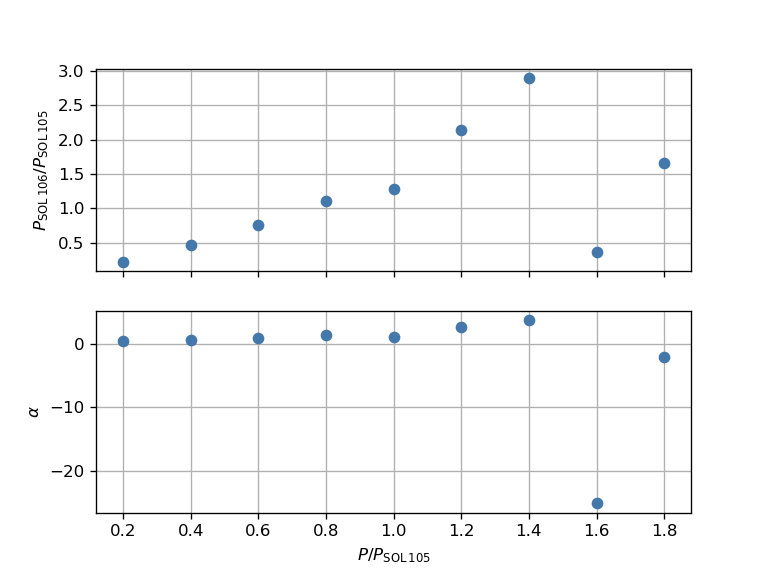

In [41]:
# Plot nonlinear buckling loads and critical buckling factors vs applied loads
_, axs = plt.subplots(nrows=2, ncols=1, sharex="all")  # figure with 2 subplots
axs[0].plot(
    load_scale_factors[:-1], nondimensional_nonlinear_buckling_loads, "o"
)  # buckling loads vs applied loads
axs[1].plot(
    load_scale_factors[:-1], critical_buckling_factors, "o"
)  # critical buckling factors vs applied loads

# Set plot appearance
axs[0].set_ylabel("$P_\mathrm{SOL\/106}/P_\mathrm{SOL\/105}$")
axs[0].grid(visible=True)
axs[1].set_ylabel("$\\alpha$")
axs[1].grid(visible=True)
axs[1].set_xlabel("$P/P_\mathrm{SOL\/105}$")
plt.show()

We observe that for the uCRM-9, the nonlinear buckling method is not able to predict the same buckling load as SOL 105 for the initial linear range of the structural response of the structure. Actually, for low applied load levels there appears to be a linear relationship between nonlinear buckling load and applied load. It is not clear why this happens, considering the linear structural response observed on the natural path. This sheds doubts on the reliability of the nonlinear buckling method for structures more complicated than a simple box beam, like the uCRM-9.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have investigated the nonlinear structural response of the uCRM-9. We applied the 1g aerodynamic load and scaled it uniformly for all our analyses, obtaining in this way a pseudo-aerodynamic load. We found the critical buckling load predicted by the linear buckling analysis and then we investigated the effect of the nonlinear analysis parameters on the results by applying twice the linear buckling load and by looking at the changes of the load-displacement curve as the parameters were varied. We were able to identify a complementary path disconnected from the natural path of the structure, however the nonlinearities along the path revealed to be too complex to be handled by Nastran's implementation of the arc-length solver. Finally we carried out a verification of SOL 106's nonlinear buckling method and we found out that the latter was not able to reproduce the linear buckling load for the initial linear range of the structural response, thus making it an unreliable method for the nonlinear stability analysis of a wingbox structure like the one of the uCRM-9.

In conclusion, we propose to drop the use of the expression "nonlinear buckling", as it can be misleading. In fact, the term buckling is usually associated to linear approaches, where the underlying concept is the one of a discrete event and of a binary state of the structure. In other words, either the structure has buckled, implying that it has failed, or it has not buckled, implying that it is safe. From a mathematical point of view, this discrete nature of the buckling event is reflected in the eigenvalue problem that is solved to predict the critical buckling load, where the problem is formulated in such a way to find the multiplicative factor of the differential stiffness matrix that makes the determinant of the global stiffness matrix equal to zero.

Nastran's nonlinear buckling method is based on a very similar idea, where the differential stiffness matrix is assembled from the solutions of the last two converged increments and the eigenvalue problem is based on the tangent stiffness matrix of the last converged increment. However, this is still a linearization and the problem is still set up to ask for a point where the global stiffness matrix becomes singular, without considering the possibility that the stiffness matrix does not become singular because of the nonlinearities. For this reason, in the continuation of our studies, we are going to talk about nonlinear structural stability rather than nonlinear buckling, and we are going to focus on the use of the eigenvalues of the tangent stiffness matrix as the indicators of the stability of the equilibrium points of the structure.